Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


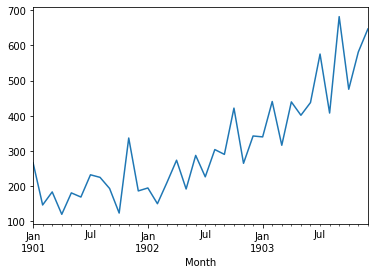

In [2]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('datatest.txt', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

0) TrainRMSE=60.936668, TestRMSE=98.644226
1) TrainRMSE=61.962191, TestRMSE=106.443184
2) TrainRMSE=61.917341, TestRMSE=87.581253
3) TrainRMSE=63.280102, TestRMSE=96.465554
4) TrainRMSE=62.255826, TestRMSE=92.912390
5) TrainRMSE=59.083976, TestRMSE=99.141417
6) TrainRMSE=61.775404, TestRMSE=93.260709
7) TrainRMSE=62.662005, TestRMSE=94.567011
8) TrainRMSE=62.577284, TestRMSE=96.477401
9) TrainRMSE=72.712886, TestRMSE=103.120823


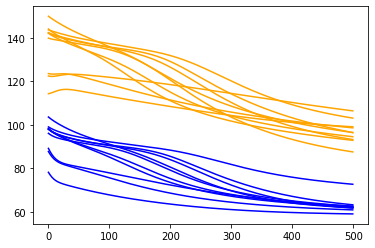

In [4]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df = df.drop(0)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
	# separate
	X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
	# reshape
	reshaped = X.reshape(len(X), 1, 1)
	# forecast dataset
	output = model.predict(reshaped, batch_size=batch_size)
	# invert data transforms on forecast
	predictions = list()
	for i in range(len(output)):
		yhat = output[i,0]
		# invert scaling
		yhat = invert_scale(scaler, X[i], yhat)
		# invert differencing
		yhat = yhat + raw_data[i]
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
	return rmse

# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# prepare model
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit model
	train_rmse, test_rmse = list(), list()
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
		# evaluate model on train data
		raw_train = raw[-(len(train)+len(test)+1):-len(test)]
		train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
		model.reset_states()
		# evaluate model on test data
		raw_test = raw[-(len(test)+1):]
		test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
		model.reset_states()
	history = DataFrame()
	history['train'], history['test'] = train_rmse, test_rmse
	return history

# run diagnostic experiments
def run():
	# load dataset
	series = read_csv('datatest.txt', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# fit and evaluate model
	train_trimmed = train_scaled[2:, :]
	# config
	repeats = 10
	n_batch = 4
	n_epochs = 500
	n_neurons = 1
	# run diagnostic tests
	for i in range(repeats):
		history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
		pyplot.plot(history['train'], color='blue')
		pyplot.plot(history['test'], color='orange')
		print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
	pyplot.savefig('epochs_diagnostic.png')

# entry point
run()